In [1]:
import torch
import gymnasium as gym
import torch.nn as nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [2]:
gym.__version__

'1.2.3'

In [3]:
class PolicyNetwork():
    def __init__(self, n_state, n_action, n_hidden=50, lr=0.001):

        self.model = nn.Sequential(
                        nn.Linear(n_state, n_hidden),
                        nn.ReLU(),
                        nn.Linear(n_hidden, n_action),
                        nn.Softmax(dim=-1),
                )

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr)


    def predict(self, s):
        """
        Compute the action probabilities of state s using the learning model
        @param s: input state
        @return: predicted policy
        """
        return self.model(torch.Tensor(np.array(s)))


    def update(self, advantages, log_probs):
        """
        Update the weights of the policy network given the training samples
        @param advantages: advantage for each step in an episode
        @param log_probs: log probability for each step
        """
        policy_gradient = []
        for log_prob, Gt in zip(log_probs, advantages):
            policy_gradient.append(-log_prob * Gt)

        loss = torch.stack(policy_gradient).sum()
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


    def get_action(self, s):
        """
        Estimate the policy and sample an action, compute its log probability
        @param s: input state
        @return: the selected action and log probability
        """
        probs = self.predict(s)
        action = torch.multinomial(probs, 1).item()
        log_prob = torch.log(probs[action])
        return action, log_prob

In [4]:
class ValueNetwork():
    def __init__(self, n_state, n_hidden=50, lr=0.05):
        self.criterion = torch.nn.MSELoss()
        self.model = torch.nn.Sequential(
                        torch.nn.Linear(n_state, n_hidden),
                        torch.nn.ReLU(),
                        torch.nn.Linear(n_hidden, 1)
                )
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr)


    def update(self, s, y):
        """
        Update the weights of the DQN given a training sample
        @param s: states
        @param y: target values
        """
        y_pred = self.model(torch.Tensor(np.array(s)))[:, 0]
        loss = self.criterion(y_pred, Variable(torch.Tensor(y)))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


    def predict(self, s):
        """
        Compute the Q values of the state for all actions (V function) using the learning model
        @param s: input state
        @return: Q values of the state for all actions (V function)
        """
        with torch.no_grad():
            return self.model(torch.Tensor(s))

In [5]:
def reinforce(env, estimator_policy, estimator_value, n_episode, gamma=1.0):
    """
    REINFORCE algorithm with baseline
    @param env: Gym environment
    @param estimator_policy: policy network
    @param estimator_value: value network
    @param n_episode: number of episodes
    @param gamma: the discount factor
    """
    total_reward_episode = np.zeros(n_episode)

    for episode in tqdm(range(n_episode)):
        log_probs = []
        states = []
        rewards = []
        state, _ = env.reset()

        while True:
            states.append(state)
            action, log_prob = estimator_policy.get_action(state)
            next_state, reward, is_done, truncate, _ = env.step(action)

            total_reward_episode[episode] += reward
            log_probs.append(log_prob)

            rewards.append(reward)

            if is_done or truncate:
                Gt = 0
                pw = 0

                returns = []
                for t in range(len(states)-1, -1, -1):
                    Gt += gamma ** pw * rewards[t]
                    pw += 1
                    returns.append(Gt)

                returns = returns[::-1]
                returns = torch.tensor(returns)

                baseline_values = estimator_value.predict(states)

                advantages = returns - baseline_values

                estimator_value.update(states, returns)

                estimator_policy.update(advantages, log_probs)

                break


            state = next_state
    return total_reward_episode

100%|██████████| 3000/3000 [01:52<00:00, 26.64it/s]


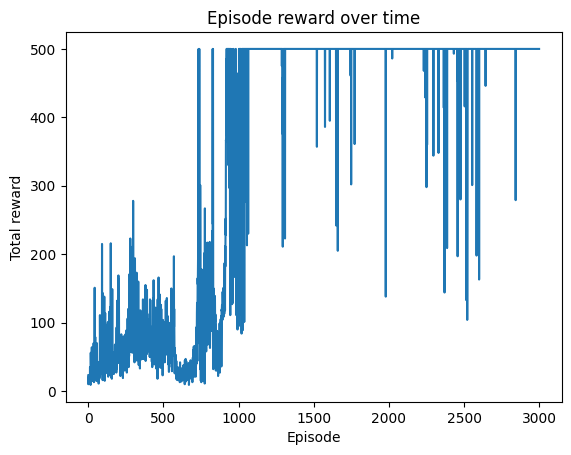

In [6]:
env = gym.make('CartPole-v1')
n_state = env.observation_space.shape[0]
n_action = env.action_space.n
n_hidden_p = 128
lr_p = 0.003
policy_net = PolicyNetwork(n_state, n_action, n_hidden_p, lr_p)

n_hidden_v = 128
lr_v = 0.003
value_net = ValueNetwork(n_state, n_hidden_v, lr_v)

n_episode = 3000
gamma = 0.95


total_reward_episode = reinforce(env, policy_net, value_net, n_episode, gamma)

plt.plot(total_reward_episode)
plt.title('Episode reward over time')
plt.xlabel('Episode')
plt.ylabel('Total reward')
plt.show()